In [2]:
!pip install tqdm

You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
import numpy as np 
import pandas as pd 
import os
import keras
from keras import layers
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.models import Model,Sequential
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Dense,Dropout,Flatten
from tqdm.auto import tqdm, trange
from PIL import Image
import shutil
import s3fs
import cv2

In [25]:
def process_img(path, size=(64, 64)):
    with fs.open(f'{path}') as file:
        img = Image.open(file)
        img_arr = np.array(img).astype('float32')
        img_tensor = cv2.resize(img_arr, dsize=size, interpolation=cv2.INTER_CUBIC)
        img_final = np.interp(img_tensor, (img_tensor.min(), img_tensor.max()), (0, 1))
        if len(img_tensor.shape) != 3:
            img_final = np.zeros(size + (3,))
    return img_final

In [4]:
from tqdm import tqdm
fs = s3fs.S3FileSystem()
path = 's3://aidan-sagemaker/art_imgs/'
filelist = fs.ls(path)
paintings32 = np.array([process_img('s3://'+fname, size = (32, 32)) for fname in tqdm(filelist)])
paintings64 = np.array([process_img('s3://'+fname, size = (64, 64)) for fname in tqdm(filelist)])

100%|██████████| 8446/8446 [12:16<00:00, 11.47it/s]


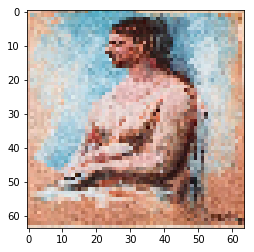

In [6]:
plt.imshow(paintings64[4900])

In [7]:
latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(128 * 16 * 16)(generator_input)  #128 16x16 feature maps
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x) 
x = layers.LeakyReLU()(x)

'''
Upsamples to 128x128
'''
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x) 
x = layers.LeakyReLU()(x)
'''
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x) 
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x) 
x = layers.LeakyReLU()(x)
'''
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x) 
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x) 
'''
Instantiates the generator model, which maps the input
of shape (latent_dim,) into an image of shape (128, 128, 3)
'''
generator = keras.models.Model(generator_input, x) 
generator.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048832   
_______

In [8]:
discriminator_input = layers.Input(shape=(height, width, channels))

x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
'''
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
'''
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)

x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x) 
discriminator.summary()

discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008,
                                                   clipvalue=1.0, 
                                                   decay=1e-8)


discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
__________________________

In [9]:
discriminator.trainable = False  #Train only the generator for this part.
gan_input = keras.Input(shape=(latent_dim,)) 
gan_output = discriminator(generator(gan_input)) 
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8) 
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [10]:
x_train = paintings32

In [11]:
iterations = 10000
batch_size = 20
save_dir = '/home/ec2-user/SageMaker/produced_art/'

start = 0
for step in tqdm(range(iterations)):
    
    #Samples random points in latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    #Decodes them to fake images
    generated_images = generator.predict(random_latent_vectors)
    
    stop = start + batch_size
    real_images = x_train[start:stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    #Assembles labels, discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    
    #Adds random noise to the labels - an important trick. 
    labels += 0.05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    '''
    Assembles labels that say "these are all real images" (it's a lie!)
    This is bc we want to reward the model if the discriminator guesses real. 
    This means discriminator is bad but generator is good; but we only care about
    updating the generator weights right now.
    '''
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
        
    if step % 100 ==0:
        gan.save_weights('gan.h5')
        
        print('discriminator loss: ', d_loss)
        print('adversarial loss: ', a_loss)
        
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_art' + str(step) + '.png'))
        
        img = image.array_to_img(real_images[0] * 255., scale = False)
        img.save(os.path.join(save_dir, 'real_art' + str(step) + '.png'))

  0%|          | 0/10000 [00:00<?, ?it/s]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


  0%|          | 1/10000 [00:05<14:41:58,  5.29s/it]

discriminator loss:  0.70391756
adversarial loss:  0.6737102


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  1%|          | 101/10000 [00:27<38:52,  4.24it/s] 

discriminator loss:  0.6585406
adversarial loss:  0.89677393


  2%|▏         | 201/10000 [00:48<38:42,  4.22it/s]

discriminator loss:  0.60847944
adversarial loss:  0.7970396


  3%|▎         | 301/10000 [01:10<38:53,  4.16it/s]

discriminator loss:  0.69391316
adversarial loss:  0.92122924


  4%|▍         | 401/10000 [01:32<38:15,  4.18it/s]

discriminator loss:  0.69840807
adversarial loss:  0.771454


  5%|▌         | 501/10000 [01:54<38:03,  4.16it/s]

discriminator loss:  0.70907676
adversarial loss:  0.7356386


  6%|▌         | 601/10000 [02:16<37:34,  4.17it/s]

discriminator loss:  0.6820109
adversarial loss:  0.77215904


  7%|▋         | 701/10000 [02:38<37:11,  4.17it/s]

discriminator loss:  0.7086183
adversarial loss:  0.74267524


  8%|▊         | 801/10000 [03:01<37:09,  4.13it/s]

discriminator loss:  0.6994994
adversarial loss:  0.80824155


  9%|▉         | 901/10000 [03:23<36:29,  4.15it/s]

discriminator loss:  0.7158422
adversarial loss:  0.83261144


 10%|█         | 1001/10000 [03:45<36:13,  4.14it/s]

discriminator loss:  0.69526255
adversarial loss:  0.741083


 11%|█         | 1101/10000 [04:07<35:54,  4.13it/s]

discriminator loss:  0.69990486
adversarial loss:  0.80702066


 12%|█▏        | 1201/10000 [04:29<35:25,  4.14it/s]

discriminator loss:  0.68703586
adversarial loss:  0.7870887


 13%|█▎        | 1301/10000 [04:51<35:09,  4.12it/s]

discriminator loss:  0.69382256
adversarial loss:  0.7363991


 14%|█▍        | 1401/10000 [05:14<34:20,  4.17it/s]

discriminator loss:  0.683578
adversarial loss:  0.8385827


 15%|█▌        | 1501/10000 [05:36<33:57,  4.17it/s]

discriminator loss:  0.687784
adversarial loss:  0.8156389


 16%|█▌        | 1601/10000 [05:58<33:49,  4.14it/s]

discriminator loss:  0.7006877
adversarial loss:  0.7505458


 17%|█▋        | 1701/10000 [06:20<33:18,  4.15it/s]

discriminator loss:  0.704963
adversarial loss:  0.7584225


 18%|█▊        | 1801/10000 [06:42<32:44,  4.17it/s]

discriminator loss:  0.6888714
adversarial loss:  0.71941715


 19%|█▉        | 1901/10000 [07:04<32:23,  4.17it/s]

discriminator loss:  0.6929344
adversarial loss:  0.9696554


 20%|██        | 2001/10000 [07:26<32:05,  4.15it/s]

discriminator loss:  0.75333107
adversarial loss:  0.6702032


 21%|██        | 2101/10000 [07:49<31:37,  4.16it/s]

discriminator loss:  0.6997391
adversarial loss:  0.81483793


 22%|██▏       | 2201/10000 [08:11<31:17,  4.15it/s]

discriminator loss:  0.6882695
adversarial loss:  0.7641228


 23%|██▎       | 2301/10000 [08:33<31:08,  4.12it/s]

discriminator loss:  0.7416844
adversarial loss:  0.8013414


 24%|██▍       | 2401/10000 [08:55<30:29,  4.15it/s]

discriminator loss:  0.68633854
adversarial loss:  0.75639063


 25%|██▌       | 2501/10000 [09:17<30:08,  4.15it/s]

discriminator loss:  0.69504356
adversarial loss:  0.8069385


 26%|██▌       | 2601/10000 [09:40<29:41,  4.15it/s]

discriminator loss:  0.70022786
adversarial loss:  0.7957772


 27%|██▋       | 2701/10000 [10:02<29:15,  4.16it/s]

discriminator loss:  0.70022714
adversarial loss:  0.76066196


 28%|██▊       | 2801/10000 [10:24<28:53,  4.15it/s]

discriminator loss:  0.69809735
adversarial loss:  0.70189035


 29%|██▉       | 2901/10000 [10:46<28:30,  4.15it/s]

discriminator loss:  0.66933954
adversarial loss:  0.7180254


 30%|███       | 3001/10000 [11:08<27:56,  4.18it/s]

discriminator loss:  0.67881954
adversarial loss:  0.85347605


 31%|███       | 3101/10000 [11:30<27:34,  4.17it/s]

discriminator loss:  0.70064
adversarial loss:  0.78985286


 32%|███▏      | 3201/10000 [11:52<27:14,  4.16it/s]

discriminator loss:  0.8287667
adversarial loss:  2.504681


 33%|███▎      | 3301/10000 [12:15<26:54,  4.15it/s]

discriminator loss:  0.6826857
adversarial loss:  0.99700797


 34%|███▍      | 3401/10000 [12:37<26:23,  4.17it/s]

discriminator loss:  0.6807096
adversarial loss:  0.79449016


 35%|███▌      | 3501/10000 [12:59<26:03,  4.16it/s]

discriminator loss:  0.62154615
adversarial loss:  0.86001223


 36%|███▌      | 3601/10000 [13:21<25:45,  4.14it/s]

discriminator loss:  0.6812141
adversarial loss:  0.7663089


 37%|███▋      | 3701/10000 [13:43<25:24,  4.13it/s]

discriminator loss:  0.6168017
adversarial loss:  0.9064366


 38%|███▊      | 3801/10000 [14:05<24:52,  4.15it/s]

discriminator loss:  0.79209775
adversarial loss:  1.1907625


 39%|███▉      | 3901/10000 [14:27<29:06,  3.49it/s]

discriminator loss:  0.72498196
adversarial loss:  0.79484564


 40%|████      | 4001/10000 [14:49<24:08,  4.14it/s]

discriminator loss:  0.6820227
adversarial loss:  0.843063


 41%|████      | 4101/10000 [15:12<23:44,  4.14it/s]

discriminator loss:  0.6804814
adversarial loss:  0.8742566


 42%|████▏     | 4201/10000 [15:34<23:12,  4.16it/s]

discriminator loss:  0.69262564
adversarial loss:  0.7266766


 43%|████▎     | 4301/10000 [15:56<22:52,  4.15it/s]

discriminator loss:  0.64624083
adversarial loss:  0.8291422


 44%|████▍     | 4401/10000 [16:18<22:27,  4.15it/s]

discriminator loss:  0.740875
adversarial loss:  0.77579373


 45%|████▌     | 4501/10000 [16:40<22:03,  4.15it/s]

discriminator loss:  0.6630018
adversarial loss:  0.79393196


 46%|████▌     | 4601/10000 [17:02<21:45,  4.13it/s]

discriminator loss:  0.6823233
adversarial loss:  0.8785412


 47%|████▋     | 4701/10000 [17:25<21:16,  4.15it/s]

discriminator loss:  0.5794414
adversarial loss:  0.8404729


 48%|████▊     | 4801/10000 [17:47<20:59,  4.13it/s]

discriminator loss:  0.6544995
adversarial loss:  1.7497823


 49%|████▉     | 4901/10000 [18:09<20:28,  4.15it/s]

discriminator loss:  0.68798625
adversarial loss:  0.8666655


 50%|█████     | 5001/10000 [18:31<20:03,  4.15it/s]

discriminator loss:  0.68914485
adversarial loss:  0.90316975


 51%|█████     | 5101/10000 [18:53<19:39,  4.15it/s]

discriminator loss:  0.60608256
adversarial loss:  1.0089668


 52%|█████▏    | 5201/10000 [19:15<19:21,  4.13it/s]

discriminator loss:  0.57763
adversarial loss:  0.9508103


 53%|█████▎    | 5301/10000 [19:37<18:42,  4.19it/s]

discriminator loss:  0.7128218
adversarial loss:  0.777793


 54%|█████▍    | 5401/10000 [20:00<18:33,  4.13it/s]

discriminator loss:  0.57910097
adversarial loss:  1.2900324


 55%|█████▌    | 5501/10000 [20:22<18:00,  4.16it/s]

discriminator loss:  0.6469544
adversarial loss:  0.10628003


 56%|█████▌    | 5601/10000 [20:44<17:35,  4.17it/s]

discriminator loss:  0.6111644
adversarial loss:  4.3815155


 57%|█████▋    | 5701/10000 [21:06<17:16,  4.15it/s]

discriminator loss:  0.8163806
adversarial loss:  3.751447


 58%|█████▊    | 5801/10000 [21:28<16:54,  4.14it/s]

discriminator loss:  0.6733653
adversarial loss:  0.88261175


 59%|█████▉    | 5901/10000 [21:50<16:24,  4.16it/s]

discriminator loss:  0.6862136
adversarial loss:  0.8892028


 60%|██████    | 6001/10000 [22:13<15:58,  4.17it/s]

discriminator loss:  0.69214034
adversarial loss:  0.7215495


 61%|██████    | 6101/10000 [22:35<15:37,  4.16it/s]

discriminator loss:  0.654693
adversarial loss:  1.5955898


 62%|██████▏   | 6201/10000 [22:57<15:17,  4.14it/s]

discriminator loss:  0.6974955
adversarial loss:  0.7586109


 63%|██████▎   | 6301/10000 [23:19<14:47,  4.17it/s]

discriminator loss:  0.71554595
adversarial loss:  0.8032993


 64%|██████▍   | 6401/10000 [23:41<14:27,  4.15it/s]

discriminator loss:  0.547999
adversarial loss:  1.0476477


 65%|██████▌   | 6501/10000 [24:03<14:04,  4.15it/s]

discriminator loss:  0.72202015
adversarial loss:  1.0856597


 66%|██████▌   | 6601/10000 [24:25<13:38,  4.15it/s]

discriminator loss:  0.7142949
adversarial loss:  0.7336962


 67%|██████▋   | 6701/10000 [24:47<13:14,  4.15it/s]

discriminator loss:  0.5176724
adversarial loss:  2.3256435


 68%|██████▊   | 6801/10000 [25:10<12:51,  4.15it/s]

discriminator loss:  0.5991603
adversarial loss:  0.766358


 69%|██████▉   | 6901/10000 [25:32<12:25,  4.16it/s]

discriminator loss:  0.6510391
adversarial loss:  0.99192303


 70%|███████   | 7001/10000 [25:54<12:06,  4.13it/s]

discriminator loss:  0.71549094
adversarial loss:  0.93732244


 71%|███████   | 7101/10000 [26:16<11:43,  4.12it/s]

discriminator loss:  0.6883612
adversarial loss:  0.7308653


 72%|███████▏  | 7201/10000 [26:38<11:11,  4.17it/s]

discriminator loss:  0.6060399
adversarial loss:  1.2156067


 73%|███████▎  | 7301/10000 [27:00<10:50,  4.15it/s]

discriminator loss:  0.42132825
adversarial loss:  1.9725736


 74%|███████▍  | 7401/10000 [27:23<10:23,  4.17it/s]

discriminator loss:  0.67235315
adversarial loss:  0.84426534


 75%|███████▌  | 7501/10000 [27:45<09:59,  4.17it/s]

discriminator loss:  0.46547183
adversarial loss:  3.829816


 76%|███████▌  | 7601/10000 [28:07<09:37,  4.16it/s]

discriminator loss:  0.64534795
adversarial loss:  0.47155872


 77%|███████▋  | 7701/10000 [28:29<09:14,  4.15it/s]

discriminator loss:  0.71694124
adversarial loss:  0.9411851


 78%|███████▊  | 7801/10000 [28:51<08:51,  4.13it/s]

discriminator loss:  0.7122487
adversarial loss:  0.83937836


 79%|███████▉  | 7901/10000 [29:14<08:25,  4.15it/s]

discriminator loss:  0.62706584
adversarial loss:  0.8231574


 80%|████████  | 8001/10000 [29:36<08:04,  4.13it/s]

discriminator loss:  0.64527905
adversarial loss:  0.69015074


 81%|████████  | 8101/10000 [29:58<07:38,  4.14it/s]

discriminator loss:  0.7045194
adversarial loss:  0.72708833


 82%|████████▏ | 8201/10000 [30:20<07:12,  4.16it/s]

discriminator loss:  0.7090341
adversarial loss:  0.7505116


 83%|████████▎ | 8301/10000 [30:42<06:46,  4.17it/s]

discriminator loss:  0.6187483
adversarial loss:  0.9326065


 84%|████████▍ | 8401/10000 [31:05<06:23,  4.17it/s]

discriminator loss:  0.7093204
adversarial loss:  0.87152386


 85%|████████▌ | 8501/10000 [31:27<06:01,  4.15it/s]

discriminator loss:  0.83493406
adversarial loss:  0.88981706


 86%|████████▌ | 8601/10000 [31:49<05:36,  4.16it/s]

discriminator loss:  1.2614219
adversarial loss:  1.1122856


 87%|████████▋ | 8701/10000 [32:11<05:12,  4.15it/s]

discriminator loss:  0.6791354
adversarial loss:  0.8014409


 88%|████████▊ | 8801/10000 [32:33<04:49,  4.15it/s]

discriminator loss:  0.6660926
adversarial loss:  1.1085036


 89%|████████▉ | 8901/10000 [32:55<04:24,  4.16it/s]

discriminator loss:  0.69501555
adversarial loss:  0.9522465


 90%|█████████ | 9001/10000 [33:17<03:59,  4.16it/s]

discriminator loss:  0.6173526
adversarial loss:  0.9689104


 91%|█████████ | 9101/10000 [33:40<03:36,  4.15it/s]

discriminator loss:  0.6698038
adversarial loss:  0.7984584


 92%|█████████▏| 9201/10000 [34:02<03:12,  4.14it/s]

discriminator loss:  0.6456107
adversarial loss:  2.2421162


 93%|█████████▎| 9301/10000 [34:24<02:48,  4.16it/s]

discriminator loss:  0.6852754
adversarial loss:  0.761028


 94%|█████████▍| 9401/10000 [34:46<02:24,  4.15it/s]

discriminator loss:  0.76950395
adversarial loss:  0.8813244


 95%|█████████▌| 9501/10000 [35:08<02:00,  4.13it/s]

discriminator loss:  0.65876275
adversarial loss:  0.7791852


 96%|█████████▌| 9601/10000 [35:31<01:36,  4.14it/s]

discriminator loss:  0.65705985
adversarial loss:  1.4971056


 97%|█████████▋| 9701/10000 [35:53<01:12,  4.12it/s]

discriminator loss:  0.749448
adversarial loss:  0.8955595


 98%|█████████▊| 9801/10000 [36:15<00:48,  4.14it/s]

discriminator loss:  0.6851867
adversarial loss:  0.83717614


 99%|█████████▉| 9901/10000 [36:37<00:23,  4.13it/s]

discriminator loss:  0.7430526
adversarial loss:  0.357267


100%|██████████| 10000/10000 [36:59<00:00,  4.51it/s]


In [22]:
def make_art(num_of_images):
    random_latent_vectors = np.random.normal(size=(num_of_images, latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    #imgs = image.array_to_img(generated_images[0] * 255., scale=False)
    #for a in range(len(generated_images))
    imgs = np.array([img for img in generated_images])
    return imgs

In [35]:
def test_art(num_of_images):
    random_latent_vectors = np.random.normal(size=(num_of_images, latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    #imgs = image.array_to_img(generated_images[0] * 255., scale=False)
    imgs = np.array([img * 255. for img in generated_images]).astype('uint8')
    return imgs

In [56]:
artwork = make_art(9)
#plt.imshow(artwork)
#plt.imshow(artwork[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


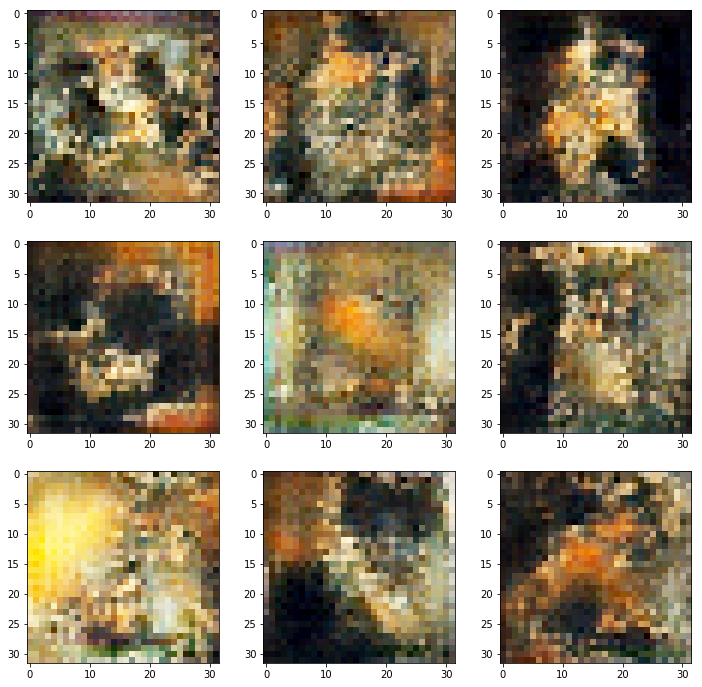

In [58]:
artwork = make_art(9)
fig, ax = plt.subplots(3,3, figsize=(12,12))
for a in range(9):
    ax[a//3, a%3].imshow(artwork[a])

## Now train on 64x64 images ##

In [10]:
latent_dim = 32
height = 64
width = 64
channels = 3

generator_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(128 * 32 * 32)(generator_input)  #128 16x16 feature maps
x = layers.LeakyReLU()(x)
x = layers.Reshape((32, 32, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x) 
x = layers.LeakyReLU()(x)

'''
Upsamples to 128x128
'''
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x) 
x = layers.LeakyReLU()(x)
'''
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x) 
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x) 
x = layers.LeakyReLU()(x)
'''
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x) 
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x) 
'''
Instantiates the generator model, which maps the input
of shape (latent_dim,) into an image of shape (128, 128, 3)
'''
generator = keras.models.Model(generator_input, x) 
generator.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 131072)            4325376   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 131072)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 256)       1048832   
_______

In [11]:
discriminator_input = layers.Input(shape=(height, width, channels))

x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
'''
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
'''
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)

x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x) 
discriminator.summary()

discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0004,
                                                   clipvalue=1.0, 
                                                   decay=1e-8)


discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)       262272    
__________________________

In [12]:
discriminator.trainable = False  #Train only the generator for this part.
gan_input = keras.Input(shape=(latent_dim,)) 
gan_output = discriminator(generator(gan_input)) 
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8) 
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

x_train = paintings64

In [28]:
iterations = 5000
batch_size = 20
save_dir = '/home/ec2-user/SageMaker/produced_art/'

start = 0
for step in tqdm(range(iterations)):
    
    #Samples random points in latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    #Decodes them to fake images
    generated_images = generator.predict(random_latent_vectors)
    
    stop = start + batch_size
    real_images = x_train[start:stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    #Assembles labels, discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    
    #Adds random noise to the labels - an important trick. 
    labels += 0.05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    '''
    Assembles labels that say "these are all real images" (it's a lie!)
    This is bc we want to reward the model if the discriminator guesses real. 
    This means discriminator is bad but generator is good; but we only care about
    updating the generator weights right now.
    '''
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
        
    if step % 100 ==0:
        gan.save_weights('/home/ec2-user/SageMaker/gan64.h5')
        
        print('discriminator loss: ', d_loss)
        print('adversarial loss: ', a_loss)
        
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_art64_' + str(step) + '.png'))
        
        img = image.array_to_img(real_images[0] * 255., scale = False)
        img.save(os.path.join(save_dir, 'real_art64_' + str(step) + '.png'))

discriminator loss:  0.88273257
adversarial loss:  0.85797787
discriminator loss:  0.6812967
adversarial loss:  1.7471602
discriminator loss:  0.69442326
adversarial loss:  0.911615
discriminator loss:  0.72026217
adversarial loss:  0.7647031
discriminator loss:  0.6946068
adversarial loss:  1.0214409
discriminator loss:  0.4618926
adversarial loss:  5.0987334
discriminator loss:  0.66639364
adversarial loss:  0.81869155
discriminator loss:  0.7032839
adversarial loss:  0.7822116
discriminator loss:  0.73282886
adversarial loss:  0.91670686
discriminator loss:  0.6950116
adversarial loss:  0.84974873
discriminator loss:  0.8876993
adversarial loss:  0.8672045
discriminator loss:  0.7499849
adversarial loss:  1.1152034
discriminator loss:  0.71439856
adversarial loss:  0.7463648
discriminator loss:  0.34858233
adversarial loss:  1.5522828
discriminator loss:  0.27588743
adversarial loss:  3.3003235
discriminator loss:  0.71763355
adversarial loss:  0.9059965
discriminator loss:  0.97980

In [4]:
import pickle as pk
paintings64 = pk.load(open('/home/ec2-user/SageMaker/images64.pkl','rb'))

In [6]:
paintings64.shape

(8446, 64, 64, 3)

In [19]:
path = '/home/ec2-user/SageMaker/'
gan.load_weights(os.path.join(path, 'gan64.h5'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


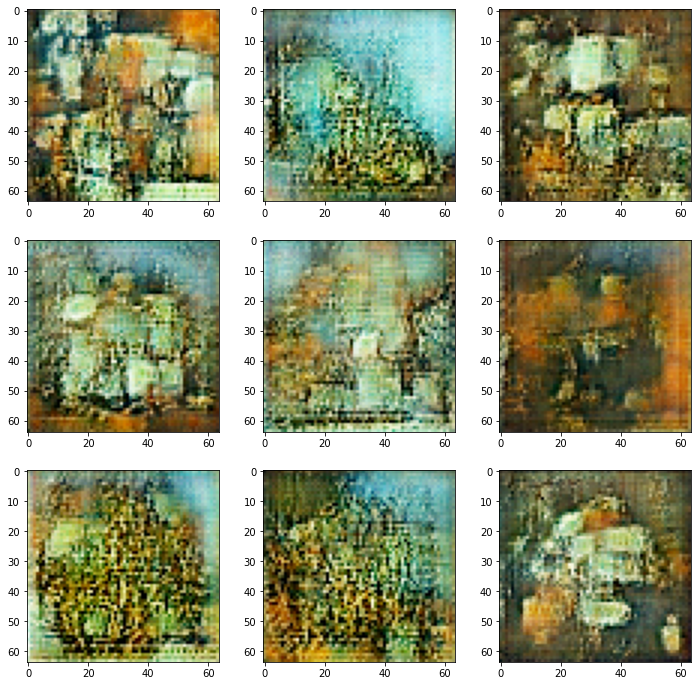

In [30]:
artwork = make_art(9)
fig, ax = plt.subplots(3,3, figsize=(12,12))
for a in range(9):
    ax[a//3, a%3].imshow(artwork[a])

In [192]:
cd SageMaker/produced_art/

/home/ec2-user/SageMaker/produced_art


In [193]:
img.save('/home/ec2-user/SageMaker/produced_art/' + str(step) + '.png')